## ANÁLISIS DE LOGS CON SPARK

Realizado por:


Deiry Sofía Navas Muriel - deiry.navas@udea.edu.co

Mateo Llano Avendaño - mateo.llano@udea.edu.co 

Kevin Martinez - kevin.martinez@udea.edu.co 
#### Incluir gráficas en los análisis


### Configuración de ambiente e importación de librerias

In [ ]:
!rm -rf spark-2.4.7-bin-hadoop2.7/ spark-2.4.7-bin-hadoop2.7.tgz

In [ ]:
# instalar ambiente de Spark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
# configuración de variables de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
# imports
import findspark
findspark.init()
from pyspark.sql import SparkSession , SQLContext
from pyspark import SparkContext,SparkConf

In [ ]:
# definir la sesion
conf = SparkConf().setAppName("log_analysis").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SQLContext(sc)

In [ ]:
#sc.stop()

In [ ]:
# otros imports de utilidad
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import operator
import itertools
import requests
import re
import pandas as pd
!pip install pygal_maps_world
!pip install geopy
!pip install folium
from pygal_maps_world.maps import World
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

### Cargar el archivo con Spark

In [ ]:
log_rdd = sc.textFile('auth.log')
log_rdd

auth.log MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

### 1. Número de líneas que hay en el archivo

In [ ]:
log_rdd.count()

102164

R// Hay 102164 líneas en el archivo

### 2. Visualizar algunos registros

In [ ]:
log_rdd.take(7)

['Mar 16 08:12:04 app-1 login[4659]: pam_unix(login:session): session opened for user user3 by LOGIN(uid=0)',
 'Mar 16 08:12:09 app-1 sudo:     user3 : TTY=tty1 ; PWD=/home/user3 ; USER=root ; COMMAND=/bin/su',
 'Mar 16 08:12:09 app-1 sudo: pam_unix(sudo:session): session opened for user root by user3(uid=0)',
 'Mar 16 08:12:09 app-1 sudo: pam_unix(sudo:session): session closed for user root',
 'Mar 16 08:12:09 app-1 su[4679]: Successful su for root by root',
 'Mar 16 08:12:09 app-1 su[4679]: + tty1 root:root',
 'Mar 16 08:12:09 app-1 su[4679]: pam_unix(su:session): session opened for user root by user3(uid=0)']

### 3. ¿Cuántos inicios de sesión exitosos?

In [ ]:
successful_user_login = log_rdd.filter(lambda x: "Accepted password" in x)
successful_user_login.count()

118

R// El número de inicios de sesión exisos son 118

### 4. ¿Qué usuarios acceden correctamente?

In [ ]:
successful_user_login = successful_user_login.collect()
successful_user_login[:5]

['Mar 16 08:26:06 app-1 sshd[4894]: Accepted password for user3 from 192.168.126.1 port 61474 ssh2',
 'Mar 16 10:14:02 app-1 sshd[5142]: Accepted password for user3 from 192.168.126.1 port 62897 ssh2',
 'Mar 16 17:12:24 app-1 sshd[5513]: Accepted password for user3 from 192.168.126.1 port 63555 ssh2',
 'Mar 18 09:42:22 app-1 sshd[4693]: Accepted password for user3 from 10.0.1.2 port 64721 ssh2',
 'Mar 18 10:00:10 app-1 sshd[4764]: Accepted password for user1 from 76.191.195.140 port 35226 ssh2']

In [ ]:
succesful_login_user_list = [line.split("Accepted password for ")[1].split(" from")[0] for line in successful_user_login]
print(len(succesful_login_user_list))
succesful_login_user_list[:5]

118


['user3', 'user3', 'user3', 'user3', 'user1']

In [ ]:
users = list(set(succesful_login_user_list)) # remove duplicates
print(users)
users_count = []
[users_count.append(succesful_login_user_list.count(user)) for user in users]
print(users_count)

['user3', 'root', 'dhg', 'user2', 'fido', 'user1']
[24, 28, 22, 5, 1, 38]


R// Hay un total de 6 usuarios que accedieron correctamente

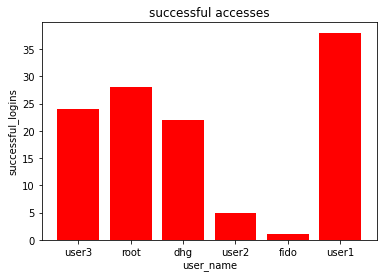

In [ ]:
plt.bar(users, users_count, color = 'red')
plt.xlabel('Nombre de usuario')
plt.ylabel('Ingresos exitosos')
plt.title('Accesos exitosos')
plt.show()

### 5. Conexiones fallidas como root 

In [ ]:
failed_connection = log_rdd.filter(lambda x: "FAILED su" in x)
print("Número de conexiones fallidas a sudo su: ", failed_connection.count())
failed_connection.collect()

Número de conexiones fallidas a sudo su:  3


['Mar 18 11:20:19 app-1 su[9504]: FAILED su for root by user1',
 'Mar 18 11:20:26 app-1 su[9506]: FAILED su for root by user1',
 'Mar 18 17:01:17 app-1 su[14542]: FAILED su for root by user3']

R// Número de conexiones fallidas a sudo su:  3

### 6. Login fallidos por usuario

In [ ]:
failed_user = log_rdd.filter(lambda x: "Failed password" in x)
failed_user.count()

20338

In [ ]:
failed_user_login = failed_user.collect()
failed_user_login[1000:1005]

['Apr 19 05:42:28 app-1 sshd[9029]: Failed password for invalid user website from 219.150.161.20 port 40720 ssh2',
 'Apr 19 05:42:29 app-1 sshd[9032]: Failed password for invalid user test123 from 219.150.161.20 port 40880 ssh2',
 'Apr 19 05:42:29 app-1 sshd[9025]: Failed password for invalid user carlota from 219.150.161.20 port 40682 ssh2',
 'Apr 19 05:42:29 app-1 sshd[9024]: Failed password for root from 219.150.161.20 port 40678 ssh2',
 'Apr 19 05:42:29 app-1 sshd[9026]: Failed password for invalid user caroleen from 219.150.161.20 port 40715 ssh2']

In [ ]:
fail_login_user_list = [line.split("Failed password for ")[1].split(" from")[0] 
                        for line in failed_user_login]
print(len(fail_login_user_list))
fail_login_user_list[:5]

20338


['user2', 'user2', 'user2', 'user2', 'root']

In [ ]:
failed_login_user_dict = Counter(fail_login_user_list) # turning list into dict
failed_login_user_dict = dict(sorted(failed_login_user_dict.items(), key=operator.itemgetter(1), reverse=True)) # descending sort by value
most_common_failed_login_users = dict(itertools.islice(failed_login_user_dict.items(), 15))
print(most_common_failed_login_users)

{'root': 5479, 'invalid user admin': 447, 'invalid user test': 282, 'invalid user administrator': 155, 'invalid user 123456': 154, 'invalid user 12345': 137, 'invalid user 123': 133, 'invalid user user': 132, 'invalid user oracle': 124, 'invalid user qwerty': 124, 'invalid user 1234': 117, 'invalid user zxcvb': 113, 'invalid user users': 105, 'invalid user abc': 95, 'invalid user abcde': 94}


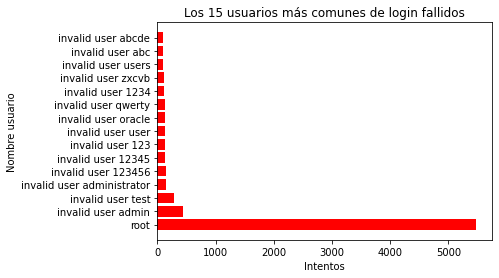

In [ ]:
plt.barh(list(most_common_failed_login_users.keys()), list(most_common_failed_login_users.values()), color = 'red')
plt.xlabel('Intentos')
plt.ylabel('Nombre usuario')
plt.title('Los 15 usuarios más comunes de login fallidos')
plt.show()

### 7. ¿Cuántos intentos de inicio de sesión son usuarios no válidos?

In [ ]:
invalid_users = log_rdd.filter(lambda line: 'Invalid user' in line)
invalid_users.count()

14478

Se realizaron 14478 intentos de sesión con usuarios no válidos

In [ ]:
invalid_users.take(7)

['Apr 19 04:36:49 app-1 sshd[6990]: Invalid user tomcat from 203.81.226.86',
 'Apr 19 05:19:08 app-1 sshd[7169]: Invalid user admin from 58.17.30.49',
 'Apr 19 05:22:10 app-1 sshd[7259]: Invalid user tina from 58.17.30.49',
 'Apr 19 05:22:14 app-1 sshd[7261]: Invalid user tom from 58.17.30.49',
 'Apr 19 05:22:19 app-1 sshd[7263]: Invalid user tom from 58.17.30.49',
 'Apr 19 05:22:23 app-1 sshd[7265]: Invalid user toor from 58.17.30.49',
 'Apr 19 05:22:28 app-1 sshd[7267]: Invalid user tour from 58.17.30.49']

In [ ]:
invalid_users = invalid_users.collect()
invalid_users_list = [line.split("Invalid user ")[1].split(" from")[0] for line in invalid_users]
print(invalid_users_list[:7])

['tomcat', 'admin', 'tina', 'tom', 'tom', 'toor', 'tour']


In [ ]:
invalid_users_dict = Counter(invalid_users_list) # turning list into dict
invalid_users_dict = dict(sorted(invalid_users_dict.items(), key=operator.itemgetter(1), reverse=True)) # descending sort by value
most_common_invalid_users = dict(itertools.islice(invalid_users_dict.items(), 15))
print(most_common_invalid_users)

{'admin': 447, 'test': 282, 'administrator': 155, '123456': 154, '12345': 137, '123': 133, 'user': 132, 'oracle': 124, 'qwerty': 124, '1234': 117, 'zxcvb': 113, 'users': 105, 'abc': 95, 'abcde': 94, 'tester': 92}


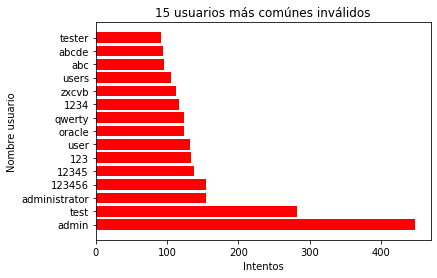

In [ ]:
plt.barh(list(most_common_invalid_users.keys()), list(most_common_invalid_users.values()), color = 'red')
plt.xlabel('Intentos')
plt.ylabel('Nombre usuario')
plt.title('15 usuarios más comúnes inválidos')
plt.show()

### 8. Nuevos usuarios creados

In [ ]:
new_users  = log_rdd.filter(lambda x: "new user" in x)
print("Cantidad de nuevos usuarios: ", new_users.count())
new_users.collect()

Cantidad de nuevos usuarios:  11


['Mar 16 08:12:13 app-1 useradd[4692]: new user: name=user4, UID=1001, GID=1001, home=/home/user4, shell=/bin/bash',
 'Mar 16 08:12:38 app-1 useradd[4703]: new user: name=user1, UID=1001, GID=1001, home=/home/user1, shell=/bin/bash',
 'Mar 16 08:12:55 app-1 useradd[4711]: new user: name=user2, UID=1002, GID=1002, home=/home/user2, shell=/bin/bash',
 'Mar 16 08:25:22 app-1 useradd[4845]: new user: name=sshd, UID=104, GID=65534, home=/var/run/sshd, shell=/usr/sbin/nologin',
 'Mar 18 10:15:42 app-1 useradd[5393]: new user: name=Debian-exim, UID=105, GID=114, home=/var/spool/exim4, shell=/bin/false',
 'Mar 18 10:18:26 app-1 useradd[6966]: new user: name=mysql, UID=106, GID=115, home=/var/lib/mysql, shell=/bin/false',
 'Apr 19 22:38:00 app-1 useradd[2019]: new user: name=packet, UID=0, GID=0, home=/home/packet, shell=/bin/sh',
 'Apr 19 22:45:13 app-1 useradd[2053]: new user: name=dhg, UID=1003, GID=1003, home=/home/dhg, shell=/bin/bash',
 'Apr 24 19:27:35 app-1 useradd[1386]: new user: name

In [ ]:
new_users = new_users.collect()
new_users_list = [line.split("name=")[1].split(",")[0] for line in new_users]
print("Nuevos usuarios creados")
new_users_list

Nuevos usuarios creados


['user4',
 'user1',
 'user2',
 'sshd',
 'Debian-exim',
 'mysql',
 'packet',
 'dhg',
 'messagebus',
 'fido',
 'wind3str0y']

R// Hay 11 nuevos usuarios creados

### 9. ¿Qué direcciones IP tienen el número de conexiones más alto para los login exitosos?

In [ ]:
list_user = successful_user_login.collect()
successful_user_login_list = [line.split("Accepted password for ")[1].split(" from")[0] for line in list_user]
successful_ip_list = [line.split(" from")[1].split(" port")[0] for line in list_user]


In [ ]:
list_user[:5]

['Mar 16 08:26:06 app-1 sshd[4894]: Accepted password for user3 from 192.168.126.1 port 61474 ssh2',
 'Mar 16 10:14:02 app-1 sshd[5142]: Accepted password for user3 from 192.168.126.1 port 62897 ssh2',
 'Mar 16 17:12:24 app-1 sshd[5513]: Accepted password for user3 from 192.168.126.1 port 63555 ssh2',
 'Mar 18 09:42:22 app-1 sshd[4693]: Accepted password for user3 from 10.0.1.2 port 64721 ssh2',
 'Mar 18 10:00:10 app-1 sshd[4764]: Accepted password for user1 from 76.191.195.140 port 35226 ssh2']

In [ ]:
successful_user_login_list[:5]

['user3', 'user3', 'user3', 'user3', 'user1']

In [ ]:
successful_ip_list[:5]

[' 192.168.126.1',
 ' 192.168.126.1',
 ' 192.168.126.1',
 ' 10.0.1.2',
 ' 76.191.195.140']

In [ ]:
id_address = Counter(successful_ip_list)
counts = id_address
index = []
data = []

In [ ]:
for k,v in counts.items():
    index.append(k)
    data.append(v)
value_counts = pd.Series(data, index)
value_counts = value_counts.sort_values(ascending=False)
value_counts.head()

 190.166.87.164    23
 76.191.195.140    22
 10.0.1.2          14
 208.80.69.74       7
 65.88.2.5          6
dtype: int64

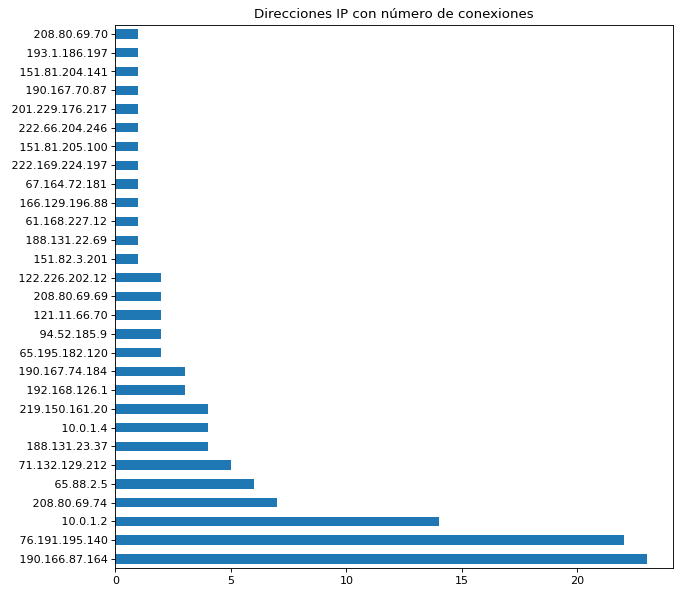

In [ ]:
plt.figure(num=None, figsize=(9, 9), dpi=80, facecolor='w', edgecolor='k')

value_counts.plot(kind="barh", title="Direcciones IP con número de conexiones")

R// Según la gráfica las primeras direcciones IPs superaran el promedio del número de conexiones exitosas, por esta razón, se afirma que la IPs: 

- 190.166.87.164 con 23 conexiones exitosas
- 76.191.195.140 con 22 conexiones exitosas
- 10.0.1.2 con 14 conexiones exitosas

### 10. Direcciones IP con inicio de sesión fallidos

In [ ]:
failed_login = log_rdd.filter(lambda line: 'Failed password' in line)

In [ ]:
failed_login.count()

20338

In [ ]:
failed_login.take(10)

['Mar 18 11:38:05 app-1 sshd[10156]: Failed password for user2 from 71.132.129.212 port 34624 ssh2',
 'Mar 18 11:38:10 app-1 sshd[10156]: Failed password for user2 from 71.132.129.212 port 34624 ssh2',
 'Mar 18 11:38:43 app-1 sshd[10156]: Failed password for user2 from 71.132.129.212 port 34624 ssh2',
 'Mar 18 11:38:59 app-1 sshd[10158]: Failed password for user2 from 71.132.129.212 port 34333 ssh2',
 'Mar 29 13:23:46 app-1 sshd[21492]: Failed password for root from 10.0.1.2 port 51771 ssh2',
 'Mar 29 13:26:46 app-1 sshd[21552]: Failed password for root from 10.0.1.2 port 51780 ssh2',
 'Apr 15 14:47:52 app-1 sshd[10174]: Failed password for user1 from 208.80.69.74 port 33737 ssh2',
 'Apr 18 18:22:09 app-1 sshd[5266]: Failed password for root from 61.151.246.140 port 52434 ssh2',
 'Apr 18 18:22:13 app-1 sshd[5268]: Failed password for root from 61.151.246.140 port 52641 ssh2',
 'Apr 18 18:22:17 app-1 sshd[5270]: Failed password for root from 61.151.246.140 port 52872 ssh2']

In [ ]:
failed_login = failed_login.collect()
failed_login_list = [line.split('from ')[1].split(' port')[0] for line in failed_login]
print(len(failed_login_list))
failed_login_list[:5]

20338


['71.132.129.212',
 '71.132.129.212',
 '71.132.129.212',
 '71.132.129.212',
 '10.0.1.2']

In [ ]:
failed_login_ip_dict = Counter(failed_login_list)
failed_login_ip_dict = dict(sorted(failed_login_ip_dict.items(), key=operator.itemgetter(1),reverse=True)) # descending sort by value
print(len(failed_login_ip_dict.items()))

46


R// Se realizaron inicios de sesión fallidos desde 46 direcciones IP diferentes

In [ ]:
most_common_failed_login_ip = dict(itertools.islice(failed_login_ip_dict.items(), 10))
print(most_common_failed_login_ip)

{'219.150.161.20': 9259, '8.12.45.242': 3037, '222.66.204.246': 1573, '121.11.66.70': 1435, '124.207.117.9': 650, '222.169.224.197': 646, '122.226.202.12': 513, '211.154.254.248': 455, '217.15.55.133': 427, '65.208.122.48': 306}


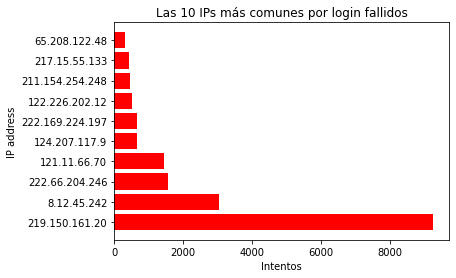

In [ ]:
plt.barh(list(most_common_failed_login_ip.keys()), list(most_common_failed_login_ip.values()), color = 'red')
plt.xlabel('Intentos')
plt.ylabel('IP address')
plt.title('Las 10 IPs más comunes por login fallidos')
plt.show()

### 11. Direcciones IP que intentaron iniciar sesión para un usuario no válido

In [19]:
failed_session  = log_rdd.filter(lambda x: ("Invalid user") in x)

failed_session.take(5)
failed_ip = failed_session.map(lambda x: x.split("from ")[1])
print("Número de inicios de sesión fallidos: ", failed_session.count() )
failed_session_list = failed_ip.collect()
failed_session_ip_dict = Counter(failed_session_list)
failed_session_ip_dict = dict(sorted(failed_session_ip_dict.items(), key=operator.itemgetter(1),reverse=True)) # descending sort by value
print("Número de IPs distintas que intentaron acceder con un usuario no válido: ", len(failed_session_ip_dict.items()))
a = [i for i in failed_session_ip_dict]
print(*a, sep = "\n")

Número de inicios de sesión fallidos:  14478
Número de IPs distintas que intentaron acceder con un usuario no válido:  28
219.150.161.20
8.12.45.242
222.66.204.246
124.207.117.9
222.169.224.197
217.15.55.133
211.154.254.248
65.208.122.48
122.226.202.12
124.51.108.68
24.192.113.91
210.68.70.170
173.9.147.165
125.235.4.130
116.6.19.70
201.64.234.2
114.80.166.219
61.168.227.12
58.17.30.49
59.46.39.148
121.11.66.70
218.56.61.114
122.165.9.200
24.94.90.96
220.170.79.247
83.216.63.124
203.81.226.86
190.166.87.164


In [21]:
most_common_no_valid_user_ip = dict(itertools.islice(failed_session_ip_dict.items(), 10))
print(most_common_no_valid_user_ip)

{'219.150.161.20': 7574, '8.12.45.242': 2842, '222.66.204.246': 1063, '124.207.117.9': 522, '222.169.224.197': 457, '217.15.55.133': 382, '211.154.254.248': 345, '65.208.122.48': 300, '122.226.202.12': 185, '124.51.108.68': 154}


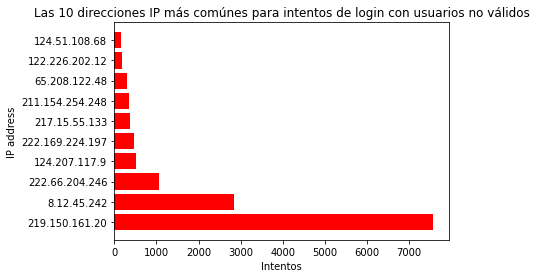

In [22]:
plt.barh(list(most_common_no_valid_user_ip.keys()), list(most_common_no_valid_user_ip.values()), color = 'red')
plt.xlabel('Intentos')
plt.ylabel('IP address')
plt.title('Las 10 direcciones IP más comúnes para intentos de login con usuarios no válidos')
plt.show()

### 12. Ubicación de las direcciones IP que intentaron iniciar sesión con un usuario no válido

In [ ]:
url = "https://demo.ip-api.com/json/116.6.19.70"
location = map(lambda x: {
    requests.request("GET", "https://demo.ip-api.com/json/"+x, headers={'Origin': "https://ip-api.com"}).text
    },failed_session_ip_dict)

locations = list(location)
#print(*list(location),  sep = "\n")
locations

[{'{"status":"success","country":"China","countryCode":"CN","region":"HA","regionName":"Henan","city":"Yingchuan","zip":"","lat":34.2904,"lon":113.382,"timezone":"Asia/Shanghai","isp":"Chinanet","org":"Chinanet HA","as":"AS4134 CHINANET-BACKBONE","query":"219.150.161.20"}'},
 {'{"status":"success","country":"United States","countryCode":"US","region":"CA","regionName":"California","city":"San Francisco","zip":"94111","lat":37.7952,"lon":-122.404,"timezone":"America/Los_Angeles","isp":"Joyent, Inc","org":"Level 3","as":"AS26464 Joyent, Inc.","query":"8.12.45.242"}'},
 {'{"status":"success","country":"China","countryCode":"CN","region":"SH","regionName":"Shanghai","city":"Shanghai","zip":"","lat":31.0449,"lon":121.4012,"timezone":"Asia/Shanghai","isp":"China Telecom (Group)","org":"Jiashang Yingke Metal (Shanghai) Co., Ltd.","as":"AS4812 China Telecom (Group)","query":"222.66.204.246"}'},
 {'{"status":"success","country":"China","countryCode":"CN","region":"BJ","regionName":"Beijing","ci

In [ ]:
countries = []
for response in locations:
  line = str(response)
  country = line.split('"country')[1]
  countries.append(re.sub(r'[^\w\s]','', country))
print(countries)

['China', 'United States', 'China', 'China', 'China', 'Russia', 'China', 'United States', 'China', 'South Korea', 'United States', 'Taiwan', 'United States', 'Vietnam', 'China', 'Brazil', 'China', 'China', 'China', 'China', 'China', 'China', 'India', 'United States', 'China', 'Italy', 'Pakistan', 'Dominican Republic']


In [ ]:
countries_dict = Counter(countries)
countries_dict

Counter({'Brazil': 1,
         'China': 14,
         'Dominican Republic': 1,
         'India': 1,
         'Italy': 1,
         'Pakistan': 1,
         'Russia': 1,
         'South Korea': 1,
         'Taiwan': 1,
         'United States': 5,
         'Vietnam': 1})

In [ ]:
countries_code = []
for response in locations:
  line = str(response)
  country = line.split('"countryCode')[1].split('region')[0]
  countries_code.append(re.sub(r'[^\w\s]','', country))
print(countries_code)

['CN', 'US', 'CN', 'CN', 'CN', 'RU', 'CN', 'US', 'CN', 'KR', 'US', 'TW', 'US', 'VN', 'CN', 'BR', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'IN', 'US', 'CN', 'IT', 'PK', 'DO']


In [ ]:
countries_code = map(str.lower, countries_code)
countries_code_dict = Counter(countries_code)
countries_code_dict

Counter({'br': 1,
         'cn': 14,
         'do': 1,
         'in': 1,
         'it': 1,
         'kr': 1,
         'pk': 1,
         'ru': 1,
         'tw': 1,
         'us': 5,
         'vn': 1})

In [ ]:
worldmap_chart = World()
worldmap_chart.title = 'IP locations for not valid user login attempts'
worldmap_chart.add('Number of IP addresses', countries_code_dict)
worldmap_chart.render_to_file('map.svg')

*Open generated interactive image from Files: map.svg*

In [ ]:
import json
geolocator = Nominatim()
locs = [geolocator.geocode(location) for location in countries_dict]
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
for loc in locs:
  a = str(loc)
  folium.CircleMarker(location = [loc.latitude, loc.longitude], radius=5, popup= a, fill =True).add_to(marker_cluster)
world_map

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning
